In [1]:
import tensorflow as tf
import numpy as np
import IPython.display as display
from PIL import Image
from tensorflow.keras.preprocessing import image 

tf.config.optimizer.set_jit(True)

In [2]:
def open_img(imgFileName):
    img = Image.open(imgFileName)
    return np.array(img)

def preprocess_img(img):
    img = 255 * (img+1)/2.0
    return tf.cast(img,tf.uint8)

def show(img):
    display.display(Image.fromarray(np.array(img)))

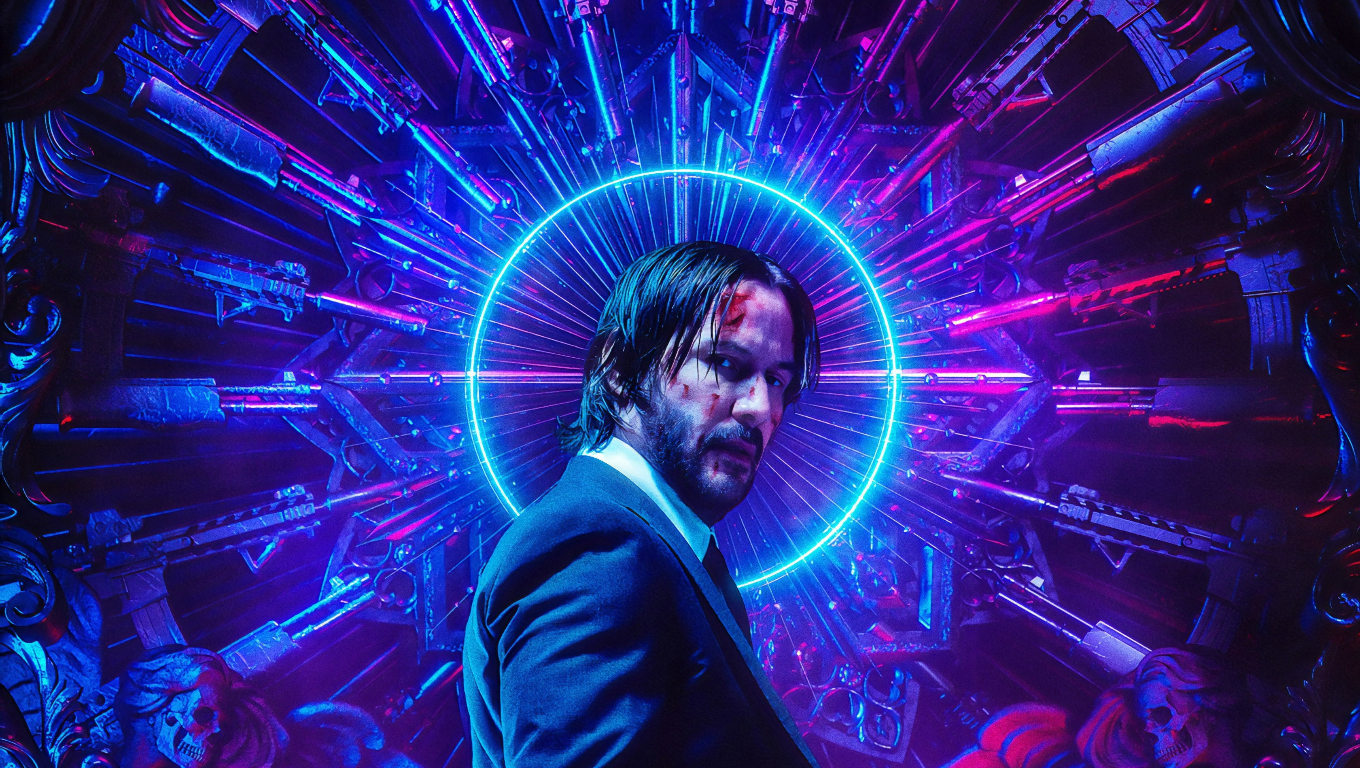

In [3]:
img = open_img("John Wick.jpg")
show(img)

In [4]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights="imagenet")

In [5]:
layer_names = ['mixed0','mixed1']
layers = [base_model.get_layer(layer_name).output for layer_name in layer_names]

deepdream_model = tf.keras.Model(inputs=base_model.input,outputs=layers)

In [6]:
def loss_calc(img,model):
    img_batch = tf.expand_dims(img,axis=0)
    layer_activations = model(img_batch)
    if len(layer_activations) == 1:
        layer_activations = [layer_activations]
    losses = []
    for act in layer_activations:
        loss = tf.reduce_mean(act)
        losses.append(loss)
    return tf.reduce_sum(losses)

In [7]:
class DeepDream(tf.Module):
    def __init__(self,model):
        self.model = model

    @tf.function(
        input_signature=(
            tf.TensorSpec(shape=[None,None,3],dtype=tf.float32),
            tf.TensorSpec(shape=[],dtype=tf.int32),
            tf.TensorSpec(shape=[],dtype=tf.float32),
        )
    )


    def __call__(self,img,steps,step_size):
        print("Tracing")
        loss = tf.constant(0.0)
        for n in tf.range(steps):
            with tf.GradientTape() as tape:
                tape.watch(img)
                loss = loss_calc(img,self.model)
            gradients = tape.gradient(loss,img)
            gradients /= tf.math.reduce_std(gradients) + 1e-8

            img = img + gradients * step_size
            img = tf.clip_by_value(img,-1,1) #clipping between -1 and 1
        return loss, img        

In [8]:
deepdream = DeepDream(deepdream_model)

In [9]:
def run_deep_dream(img,steps=100,step_size=0.01):
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    img = tf.convert_to_tensor(img)
    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        if steps_remaining > 100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps

        loss, img = deepdream(img,run_steps,tf.constant(step_size))

        display.clear_output(wait=True)
        show(preprocess_img(img))
        print("Step: {}, Loss: {}".format(step,loss))
    
    result = preprocess_img(img)
    display.clear_output(wait=True)
    show(result)
    return result

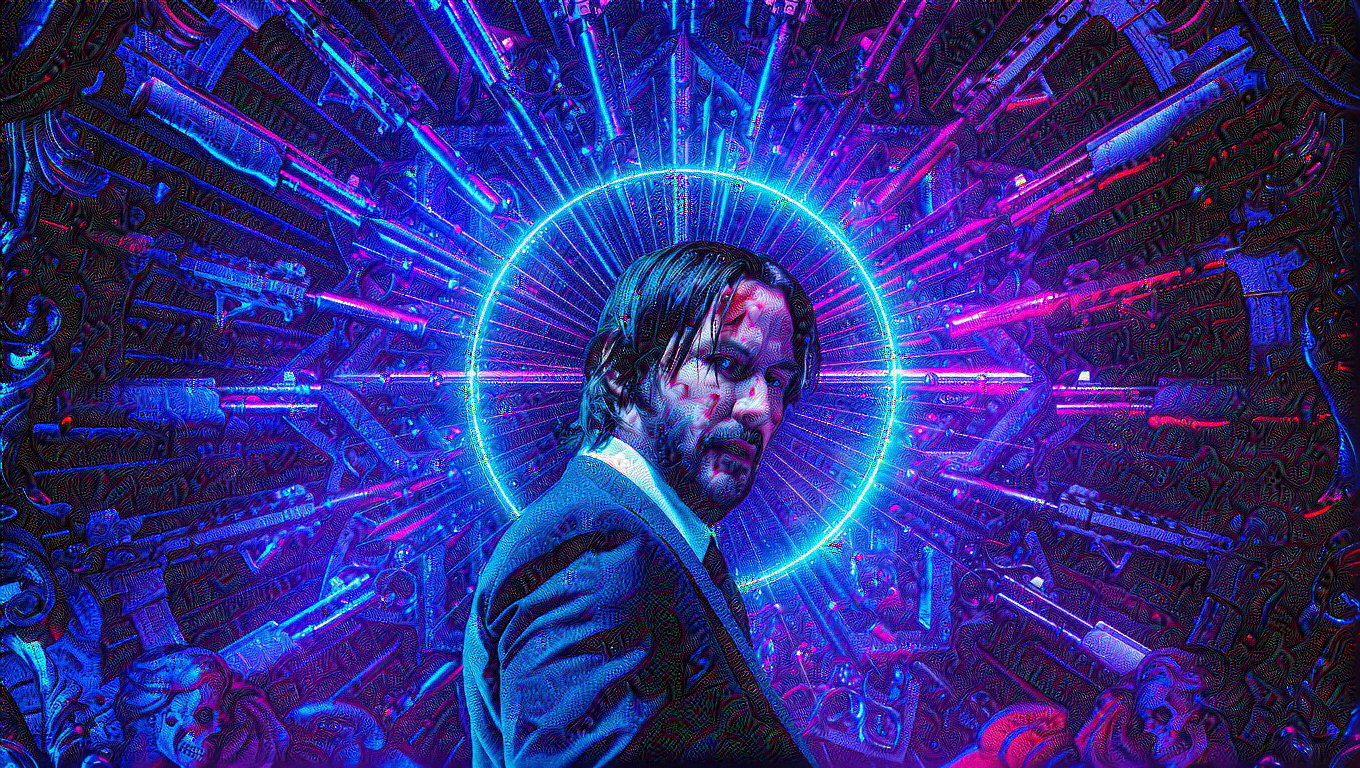

In [10]:
deepdream_img = run_deep_dream(img)

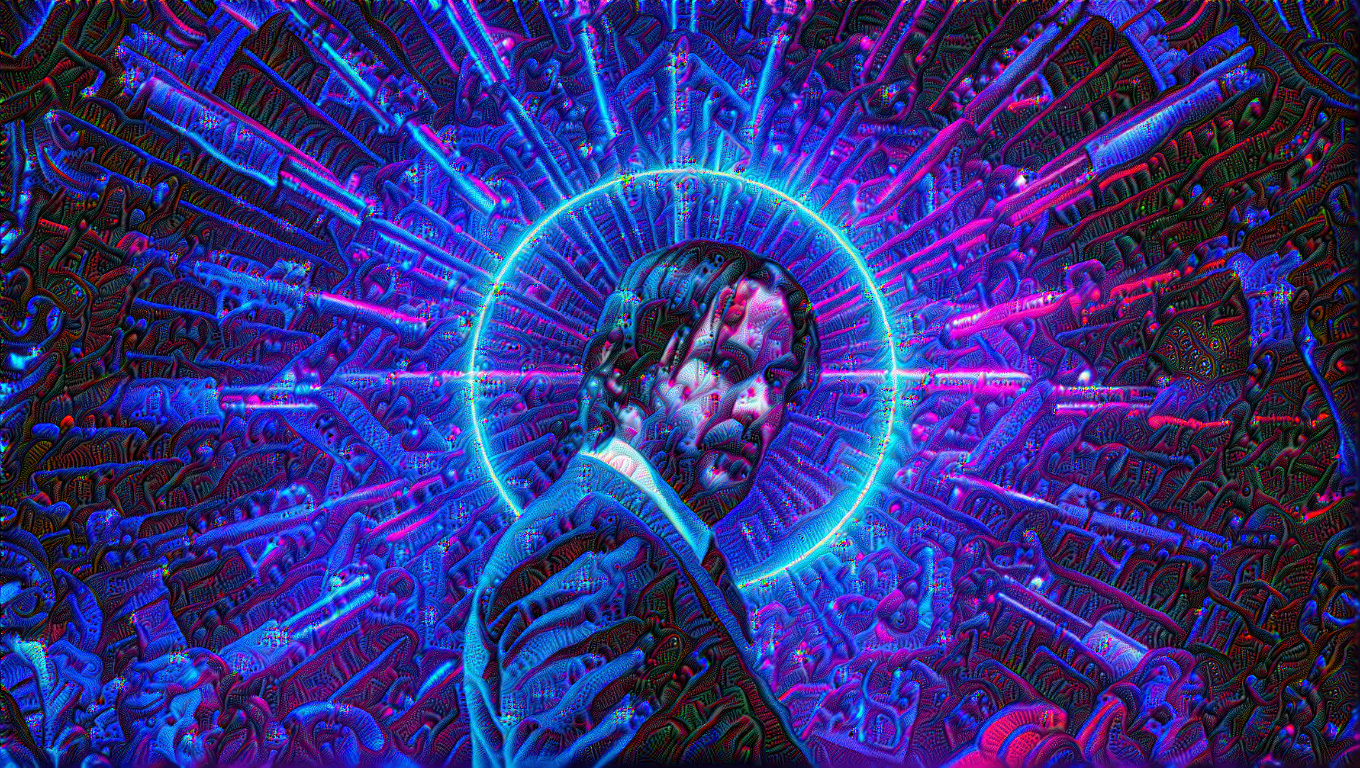

657.6184420585632

In [11]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start

In [12]:
import matplotlib.pyplot as plt 
dpi = 100
w,h = img.shape[1]/dpi, img.shape[0]/dpi
fig = plt.figure(figsize=(w,h),dpi=dpi)
fig.figimage(img)
plt.savefig("deepdream3.png")

<Figure size 1360x768 with 0 Axes>